In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the main data set
df=pd.read_csv('estimation_file_normal_fare.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (117,126) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [4]:
# read in and join the bike share updates
bsu=pd.read_csv('bike_share_update.csv',
                    encoding='utf-8')
bsu = bsu[['CBSA', 'Mode', 'Year', 'PBS_Flag_Update']]

df = df.merge(bsu, on=['CBSA', 'Mode', 'Year'], how='left')

#df['PBS_Flag_Missing'] = df['PBS_Flag'].apply(lambda x : x.isnan())
df['PBS_Flag'] = np.where(df['PBS_Flag'].isnull(), df['PBS_Flag_Update'], df['PBS_Flag'])

In [5]:
# 4 apta clusers
df['CLUSTER_APTA4'] = np.floor(df['CLUSTER_APTA']/10)

In [6]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [7]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with zero or negative fare') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']<20]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with fare greater than $20') 

# exclude problematic data
old_len = len(df)
df = df[df['HH_0Veh']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with negative 0 veh HH') 

# exclude if problem flag is set
old_len = len(df)
df = df[df['PROBLEM_FLAG']!=1]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with problem flag set to 1') 

# drop low op-ex cluster rail
old_len = len(df)
df = df[(df['CLUSTER_APTA4']!=3) |  (df['Mode']=='Bus')]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' cluster 3 rail') 



Excluding 0 records with missing VRM
Excluding 74 records with zero or negative fare
Excluding 7 records with fare greater than $20
Excluding 27 records with negative 0 veh HH
Excluding 172 records with problem flag set to 1
Excluding 31 cluster 3 rail


In [8]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 



Excluding 46 records with discontinuities in year.
Excluding 40 records with discontinuities in year.
Excluding 34 records with discontinuities in year.
Excluding 31 records with discontinuities in year.
Excluding 25 records with discontinuities in year.
Excluding 22 records with discontinuities in year.
Excluding 19 records with discontinuities in year.
Excluding 18 records with discontinuities in year.
Excluding 14 records with discontinuities in year.
Excluding 13 records with discontinuities in year.
Excluding 11 records with discontinuities in year.
Excluding 7 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 3 records with discontinuities in year.
Excluding 3 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [9]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [10]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [11]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])


In [12]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [13]:
# test rail ramp up period
df['YEARS_SINCE_RAIL_START'] = (df['Year'] - df['min_year']) * df['RAIL_FLAG']
df['YEARS_SINCE_RAIL_START'] = np.where(df['min_year']==2002, 0, df['YEARS_SINCE_RAIL_START'])

df['YEARS_SINCE_RAIL_START_1'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 1))
df['YEARS_SINCE_RAIL_START_2'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_RAIL_START_3'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 3))



In [14]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [15]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('#VALUE!', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('#VALUE!', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('#VALUE!', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('#VALUE!', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('#VALUE!', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('#VALUE!', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('#VALUE!', np.nan)


df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('N', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('N', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('N', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('N', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('N', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('N', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('N', np.nan)



In [16]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].astype(float)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].astype(float)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].astype(float)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].astype(float)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].astype(float)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].astype(float)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].astype(float)


In [17]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# flag testing introduction of new rail
df['RAIL_COMPETITION'] = np.where(df['VRM_ADJ_COMPETING']>0, 1, 0) * df['BUS_FLAG']



In [18]:
# TNC lags -- bus vs rail
df['TNC_FLAG_BUS_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['BUS_FLAG']

df['TNC_FLAG_RAIL_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['RAIL_FLAG']

# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# merge bike and scooter for bus
df['BIKE_SCOOTER_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] + df['scooter_flag_BUS']

# merge bike and scooter for bus
df['BIKE_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 

# scooter or bike
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_OR_SCOOTER_BUS'].apply(lambda x : min(x, 1))

df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 
df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_OR_SCOOTER_RAIL'].apply(lambda x : min(x, 1))

# calculate average vehicles
df['AVG_VEHS'] = (df['HH_1Veh'] + 2*df['HH_2Veh'] + 3*df['HH_3Veh'] + 4*df['HH_4+Veh']) / (df['HH_0Veh'] + df['HH_1Veh'] + df['HH_2Veh'] + df['HH_3Veh'] + df['HH_4+Veh'])
df['AVG_VEHS_log'] = np.log(1+df['AVG_VEHS'])



In [19]:
# walk bike other commuting
df['JTW_WALK_BIKE_OTHER_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT'] + df['JTW_OTHER_PCT']

# walk bike commuting
df['JTW_WALK_BIKE_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT']


In [20]:
# percent of HH in transit supportive density
df['TSD_POP_PCT'] = df['TSD_POP_PCT'] * 100

In [21]:
# segment TNCs by cluster
df['HI_OPEX']  = np.where(df['CLUSTER_APTA4']==1, 1, 0)
df['MID_OPEX'] = np.where(df['CLUSTER_APTA4']==2, 1, 0)
df['LOW_OPEX'] = np.where(df['CLUSTER_APTA4']==3, 1, 0)
df['NEW_YORK'] = np.where(df['CLUSTER_APTA4']==10, 1, 0)

df['YEARS_SINCE_TNC_BUS_HI']  = df['YEARS_SINCE_TNC_BUS'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_BUS_MID'] = df['YEARS_SINCE_TNC_BUS'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_BUS_LOW'] = df['YEARS_SINCE_TNC_BUS'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_BUS_NY']  = df['YEARS_SINCE_TNC_BUS'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_RAIL_HI']  = df['YEARS_SINCE_TNC_RAIL'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_RAIL_MID'] = df['YEARS_SINCE_TNC_RAIL'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_RAIL_LOW'] = df['YEARS_SINCE_TNC_RAIL'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_RAIL_NY']  = df['YEARS_SINCE_TNC_RAIL'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_BUS_HINY']  = df['YEARS_SINCE_TNC_BUS_HI'] + df['YEARS_SINCE_TNC_BUS_NY']
df['YEARS_SINCE_TNC_RAIL_HINY']  = df['YEARS_SINCE_TNC_RAIL_HI'] + df['YEARS_SINCE_TNC_RAIL_NY']

df['YEARS_SINCE_TNC_BUS_MIDLOW']  = df['YEARS_SINCE_TNC_BUS_MID'] + df['YEARS_SINCE_TNC_BUS_LOW']
df['YEARS_SINCE_TNC_RAIL_MIDLOW']  = df['YEARS_SINCE_TNC_RAIL_MID'] + df['YEARS_SINCE_TNC_RAIL_LOW']

In [22]:
# bikes and scooters by segment

df['BIKE_SHARE_HI']  = df['BIKE_SHARE'] * df['HI_OPEX']
df['BIKE_SHARE_MID'] = df['BIKE_SHARE'] * df['MID_OPEX']
df['BIKE_SHARE_LOW'] = df['BIKE_SHARE'] * df['LOW_OPEX']
df['BIKE_SHARE_NY']  = df['BIKE_SHARE'] * df['NEW_YORK']

df['scooter_flag_HI']  = df['scooter_flag'] * df['HI_OPEX']
df['scooter_flag_MID'] = df['scooter_flag'] * df['MID_OPEX']
df['scooter_flag_LOW'] = df['scooter_flag'] * df['LOW_OPEX']
df['scooter_flag_NY']  = df['scooter_flag'] * df['NEW_YORK']


df['BIKE_SHARE_HINY']  = df['BIKE_SHARE_HI'] + df['BIKE_SHARE_NY']
df['BIKE_SHARE_MIDLOW']  = df['BIKE_SHARE_MID'] + df['BIKE_SHARE_LOW']

df['scooter_flag_HINY']  = df['scooter_flag_HI'] + df['scooter_flag_NY']
df['scooter_flag_MIDLOW']  = df['scooter_flag_MID'] + df['scooter_flag_LOW']

In [23]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [24]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [25]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Model Estimation Tests

In [26]:
# fully specified model  

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6381
Estimator:                   PanelOLS   R-squared (Between):              0.9910
No. Observations:                3746   R-squared (Within):               0.6381
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9909
Time:                        11:31:24   Log-likelihood                    1958.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      383.32
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(16,3478)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             383.32
                            

In [27]:
# fully specified model  

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + Tot_NonUSA_POP_pct \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_1 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + MAINTENANCE_WMATA \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6389
Estimator:                   PanelOLS   R-squared (Between):              0.9917
No. Observations:                3746   R-squared (Within):               0.6389
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9916
Time:                        11:31:25   Log-likelihood                    1962.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      341.64
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(18,3476)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             341.64
                            

In [28]:
# simplified model
# drops rail ramp up, rail competition, and immigrant population, which are all insignificant

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + MAINTENANCE_WMATA \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6387
Estimator:                   PanelOLS   R-squared (Between):              0.9926
No. Observations:                3746   R-squared (Within):               0.6387
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9925
Time:                        11:31:25   Log-likelihood                    1961.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      409.94
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(15,3479)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             409.94
                            

In [29]:
# model with combined maintenance

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + MAINTENANCE \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6383
Estimator:                   PanelOLS   R-squared (Between):              0.9927
No. Observations:                3746   R-squared (Within):               0.6383
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9926
Time:                        11:31:26   Log-likelihood                    1959.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      409.38
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(15,3479)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             409.38
                            

In [30]:
# drop maintenance

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6383
Estimator:                   PanelOLS   R-squared (Between):              0.9927
No. Observations:                3746   R-squared (Within):               0.6383
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9926
Time:                        11:31:26   Log-likelihood                    1959.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      438.57
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(14,3480)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             438.57
                            

In [31]:
# segment VRM by bus vs rail -- don't keep this.

df['VRM_ADJ_BUS_log'] = df['VRM_ADJ_log'] * df['BUS_FLAG']
df['VRM_ADJ_RAIL_log'] = df['VRM_ADJ_log'] * df['RAIL_FLAG']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6567
Estimator:                   PanelOLS   R-squared (Between):              0.9743
No. Observations:                3746   R-squared (Within):               0.6567
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9760
Time:                        11:31:27   Log-likelihood                    2056.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      443.60
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(15,3479)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             443.60
                            

In [32]:
# segment TNCS cluster

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6582
Estimator:                   PanelOLS   R-squared (Between):              0.9768
No. Observations:                3746   R-squared (Within):               0.6582
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9784
Time:                        11:31:27   Log-likelihood                    2065.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      371.80
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(18,3476)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             371.80
                            

In [35]:
# same thing but without the VRM segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6408
Estimator:                   PanelOLS   R-squared (Between):              0.9942
No. Observations:                3746   R-squared (Within):               0.6408
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9941
Time:                        11:32:17   Log-likelihood                    1972.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      364.85
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(17,3477)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             364.85
                            

In [36]:
# merge bike and scooter

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6401
Estimator:                   PanelOLS   R-squared (Between):              0.9944
No. Observations:                3746   R-squared (Within):               0.6401
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9943
Time:                        11:32:39   Log-likelihood                    1968.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      412.56
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(15,3479)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             412.56
                            

In [37]:
# merge low and mid TNCs

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6401
Estimator:                   PanelOLS   R-squared (Between):              0.9945
No. Observations:                3746   R-squared (Within):               0.6401
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9944
Time:                        11:32:47   Log-likelihood                    1968.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      442.05
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(14,3480)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             442.05
                            

In [38]:
# separate VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6581
Estimator:                   PanelOLS   R-squared (Between):              0.9768
No. Observations:                3746   R-squared (Within):               0.6581
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9784
Time:                        11:32:58   Log-likelihood                    2064.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      446.46
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(15,3479)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             446.46
                            

In [39]:
# separate fares
df['FARE_per_UPT_2018_BUS_log'] = df['FARE_per_UPT_2018_log'] * df['BUS_FLAG']
df['FARE_per_UPT_2018_RAIL_log'] = df['FARE_per_UPT_2018_log'] * df['RAIL_FLAG']

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_BUS_log \
                    + FARE_per_UPT_2018_RAIL_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6615
Estimator:                   PanelOLS   R-squared (Between):              0.9707
No. Observations:                3746   R-squared (Within):               0.6615
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9727
Time:                        11:33:07   Log-likelihood                    2083.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      424.73
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(16,3478)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             424.73
                            

In [40]:
# merge TNCs again

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_BUS_log \
                    + FARE_per_UPT_2018_RAIL_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6600
Estimator:                   PanelOLS   R-squared (Between):              0.9677
No. Observations:                3746   R-squared (Within):               0.6600
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9700
Time:                        11:33:27   Log-likelihood                    2075.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      482.46
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(14,3480)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             482.46
                            

In [41]:
# merge fare and VRM

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6376
Estimator:                   PanelOLS   R-squared (Between):              0.9929
No. Observations:                3746   R-squared (Within):               0.6376
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9928
Time:                        11:34:20   Log-likelihood                    1955.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      510.46
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(12,3482)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             510.46
                            

In [42]:
# bike share segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6383
Estimator:                   PanelOLS   R-squared (Between):              0.9927
No. Observations:                3746   R-squared (Within):               0.6383
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9926
Time:                        11:34:30   Log-likelihood                    1959.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      438.57
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(14,3480)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             438.57
                            

In [43]:
# merge low and mid TNCs

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6401
Estimator:                   PanelOLS   R-squared (Between):              0.9945
No. Observations:                3746   R-squared (Within):               0.6401
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9944
Time:                        11:34:48   Log-likelihood                    1968.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      442.05
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(14,3480)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             442.05
                            

In [44]:
# separate bike share and scooter effect for HI vs MIDLOW -- don't use this


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE_HINY \
                    + BIKE_SHARE_MIDLOW \
                    + scooter_flag_HINY \
                    + scooter_flag_MIDLOW \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6405
Estimator:                   PanelOLS   R-squared (Between):              0.9948
No. Observations:                3746   R-squared (Within):               0.6405
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9947
Time:                        11:35:07   Log-likelihood                    1970.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      387.27
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(16,3478)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             387.27
                            

In [45]:
# testing

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6376
Estimator:                   PanelOLS   R-squared (Between):              0.9929
No. Observations:                3746   R-squared (Within):               0.6376
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9928
Time:                        11:35:31   Log-likelihood                    1955.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      510.46
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(12,3482)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             510.46
                            

In [46]:
# testing

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6581
Estimator:                   PanelOLS   R-squared (Between):              0.9768
No. Observations:                3746   R-squared (Within):               0.6581
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9784
Time:                        11:35:39   Log-likelihood                    2064.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      446.46
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(15,3479)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             446.46
                            

In [47]:
# testing

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6566
Estimator:                   PanelOLS   R-squared (Between):              0.9742
No. Observations:                3746   R-squared (Within):               0.6566
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9759
Time:                        11:36:00   Log-likelihood                    2056.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      512.10
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(13,3481)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             512.10
                            

## Run some analytics

In [71]:
# Final Model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6376
Estimator:                   PanelOLS   R-squared (Between):              0.9929
No. Observations:                3746   R-squared (Within):               0.6376
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9928
Time:                        02:33:37   Log-likelihood                    1955.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      510.46
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(12,3482)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             510.46
                            

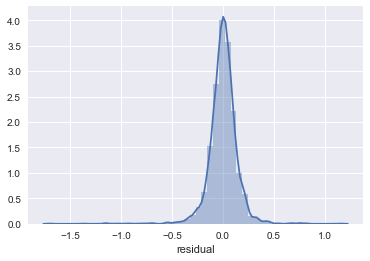

In [72]:
sns.distplot(res.resids)

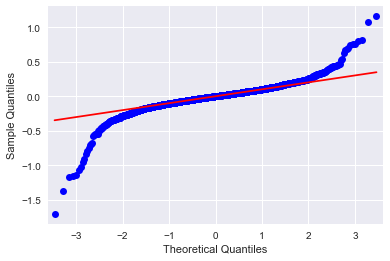

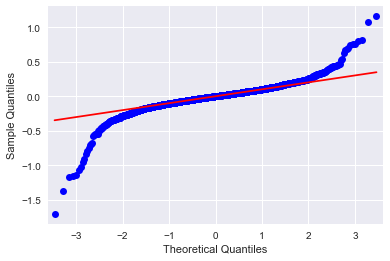

In [73]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [74]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [75]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
Akron, OH Metro Area-Bus 2002          0            24    15.469231   
                         2003          0            24    15.501150   
                         2004          0            24    15.591676   
                         2005          0            24    15.609548   
                         2006          0            24    15.619001   

                               VRM_ADJ_log  FARE_per_UPT_2018_log  \
Akron, OH Metro Area-Bus 2002    15.208377               0.148254   
                         2003    15.195930               0.462904   
                         2004    15.277699               0.414204   
                         2005    15.214971               0.460804   
                         2006    15.200501               0.462420   

                               POP_EMP_log  GAS_PRICE_2018_log  \
Akron, OH Metro Area-Bus 2002    13.808216            1.066089   
                         2003    13.823451            1.138954   
                         2004    13.839439            1.233697   
                         2005    13.857195            1.361617   
                         2006    13.879496            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  PCT_HH_NO_VEH  \
Akron, OH Metro Area-Bus 2002                     10.479210           8.60   
                         2003                     10.446267           8.20   
                         2004                     10.403980           7.79   
                         2005                     10.365663           7.47   
                         2006                     10.305856           6.85   

                               TSD_POP_PCT  JTW_HOME_PCT  YEARS_SINCE_TNC_BUS  \
Akron, OH Metro Area-Bus 2002    18.525984           3.1                  0.0   
                         2003    18.076969           3.1                  0.0   
                         2004    17.637662           3.1                  0.0   
                         2005    17.243546           3.1                  0.0   
                         2006    16.754287           2.5                  0.0   

                               YEARS_SINCE_TNC_RAIL  BIKE_SHARE  scooter_flag  \
Akron, OH Metro Area-Bus 2002                   0.0         0.0           0.0   
                         2003                   0.0         0.0           0.0   
                         2004                   0.0         0.0           0.0   
                         2005                   0.0         0.0           0.0   
                         2006                   0.0         0.0           0.0   

                                effects  residual  
Akron, OH Metro Area-Bus 2002  1.058656 -0.130628  
                         2003  1.058656 -0.000154  
                         2004  1.058656 -0.023848  
                         2005  1.058656  0.018871  
                         2006  1.058656 -0.000043

In [76]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [77]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

# for tracking new systems
app_data['UPT_ADJ_first_year'] = 0
app_data['UPT_ADJ_new_reporter'] = 0


In [ ]:
# get the ridership in the first year the system starts. This allows us to track new systems. 
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()
    first_year = years[0]

    app_data.loc[(id,first_year),'UPT_ADJ_new_reporter'] = app_data.loc[(id,first_year),'UPT_ADJ']
    
    for year in years: 
        app_data.loc[(id,year),'UPT_ADJ_first_year']   = app_data.loc[(id,first_year),'UPT_ADJ']


In [ ]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'effects'] 
                                                    - app_data.loc[(id,base_year), 'effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])
        

In [ ]:
# calculate the FAC
app_data['FAC_Sum'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['FAC_Sum'] = app_data['FAC_Sum'] + app_data[var+'_FAC']


In [ ]:

# total FAC is based on the fitted model (applied multiplicitively)
app_data['Known_FAC'] = (app_data['fitted_exp_ratio'] - 1) * app_data['UPT_ADJ_base']

# uknown change is the difference between the observed change and the known change
app_data['Unknown_FAC'] = app_data['UPT_ADJ_diff'] - app_data['Known_FAC']

# the change in ridership associated new systems
app_data['New_Reporter_FAC'] = app_data['UPT_ADJ_new_reporter'] 

# should be teh same as UPT_ADJ_DIFF
app_data['Total_Change'] = app_data['Known_FAC'] + app_data['Unknown_FAC'] + app_data['New_Reporter_FAC']


In [ ]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [ ]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [ ]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4',    
              'UPT_ADJ_first_year', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['FAC_Sum', 'Known_FAC', 'Unknown_FAC', 'New_Reporter_FAC', 'Total_Change']
    
# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [ ]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_base']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['CLUSTER_APTA4', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_base']
    

In [ ]:

summary_data_apta4.to_csv('FAC_totals_APTA4_CLUSTERS.csv')
